# Live movie morphological analysis (Figure 1)

### Imports

In [1]:
import os
import warnings
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sys import path
from glob import glob

# Suppress Seaborn + Future Warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


cwd = os.getcwd()
modules = cwd.replace('/exe/live_analysis', '')
path.insert(1, modules)

import modules.processed_data_analysis as pda

matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['pdf.use14corefonts'] = True


### Reshape dataframe for seaborn


In [2]:
# Set the path to all the json shape files
path_to_json = cwd + r'/data'

# Import all files from the folder which ends with .json 
json_files = glob(os.path.join(path_to_json, '*shape.json'))

# Initialize the dataframe
df = pd.DataFrame({
    'Exp_Date': pd.Series(dtype='str'),
    'Path_data': pd.Series(dtype='str'),
    'Name': pd.Series(dtype='str'),
    'Well_ID': pd.Series(dtype='str'),
    'Condition': pd.Series(dtype='str'),
    'Replicate': pd.Series(dtype='str'),
    'Keep_image': pd.Series(dtype='object'),
    'Microscope': pd.Series(dtype='str'),
    'Objective': pd.Series(dtype='int'),
    'Pixel_size': pd.Series(dtype='float'),
    'TimePt': pd.Series(dtype='object'),
    'Border': pd.Series(dtype='str'),
    'Area': pd.Series(dtype='object'),
    'MA_length_um': pd.Series(dtype='object'),
    'Solidity': pd.Series(dtype='object'),
    'AR': pd.Series(dtype='object'),
    'Major_Axis_um': pd.Series(dtype='object'),
    'Perimeter': pd.Series(dtype='object'),
    'Circularity': pd.Series(dtype='object'),
})

for i in range(len(json_files)):
    df_i = pd.read_json(json_files[i], orient='columns')
    df.at[i, 'Name'] = df_i.at[0, 'Name']
    df.at[i, 'Well_ID'] = df_i.at[0, 'Well_ID']
    df.at[i, 'Condition'] = df_i.at[0, 'Condition']
    df.at[i, 'Replicate'] = df_i.at[0, 'Replicate']
    df.at[i, 'Exp_Date'] = df_i.at[0, 'Exp_Date']
    df.at[i, 'Path_data'] = df_i.at[0, 'Path_data']
    for col in ['Area', 'AR', 'Major_Axis_um', 'MA_length_um', 'TimePt', 'Perimeter', 'Circularity', 'Solidity']:
        df.at[i, col] = [df_i[col].to_numpy()]

# Getting the number of time points, and their values
Time = df.loc[0, 'TimePt'][0]
n_times = len(Time)
Time

array([ 73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144])

In [3]:
df_analysis = df.copy()
df_analysis['Condition_int'] = df_analysis['Name'].apply(pda.get_cell_number)
Cond_list = np.array([50,100,300,600,1200,1800])
N_cond = Cond_list.size

metrics = ['AR', 'Area', 'Perimeter', 'Circularity']
df_reshaped_list = []

for Colname in metrics:
    ID_tot = []
    V_tot = []
    Cond_tot = []
    Time_h_tot = []

    for i in range(N_cond):
        R_i = df_analysis.loc[df_analysis['Condition_int'] == Cond_list[i], Colname]
        R_i = R_i.values.tolist()
        P_i = np.empty((len(R_i), n_times))
        Well_list = df_analysis.loc[df_analysis['Condition_int'] == Cond_list[i], 'Well_ID']
        Well_list = Well_list.values.tolist()
        W_ID = np.array(Well_list, dtype=str)

        for j in range(len(R_i)):
            if R_i[j] is not None:
                P_temp = R_i[j][0]
                P_i[j, :] = P_temp

        df_temp = pd.DataFrame(P_i, columns=Time)

        IDs = np.tile(W_ID, n_times)
        V = np.reshape(df_temp.values, (n_times * len(W_ID)))
        Cond = np.full(n_times * len(W_ID), Cond_list[i])
        Time_h = np.tile(Time, len(W_ID))

        ID_tot.extend(IDs)
        V_tot.extend(V)
        Cond_tot.extend(Cond)
        Time_h_tot.extend(Time_h)

    min_length = min(len(ID_tot), len(Cond_tot), len(Time_h_tot), len(V_tot))
    df_reshaped = pd.DataFrame({
        'Well_ID': ID_tot[:min_length], 
        'Condition_int': Cond_tot[:min_length], 
        'Time (h)': Time_h_tot[:min_length], 
        Colname: V_tot[:min_length]
    })
    df_reshaped_list.append(df_reshaped)

### Plot data before filtering

<Figure size 640x480 with 0 Axes>

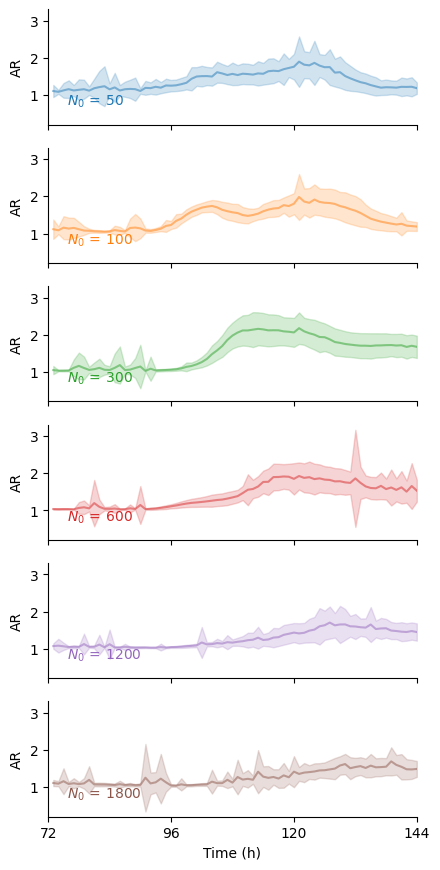

<Figure size 640x480 with 0 Axes>

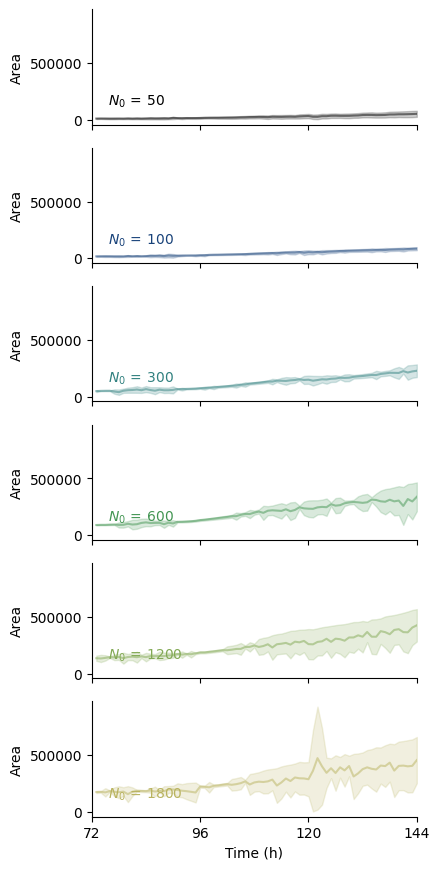

<Figure size 640x480 with 0 Axes>

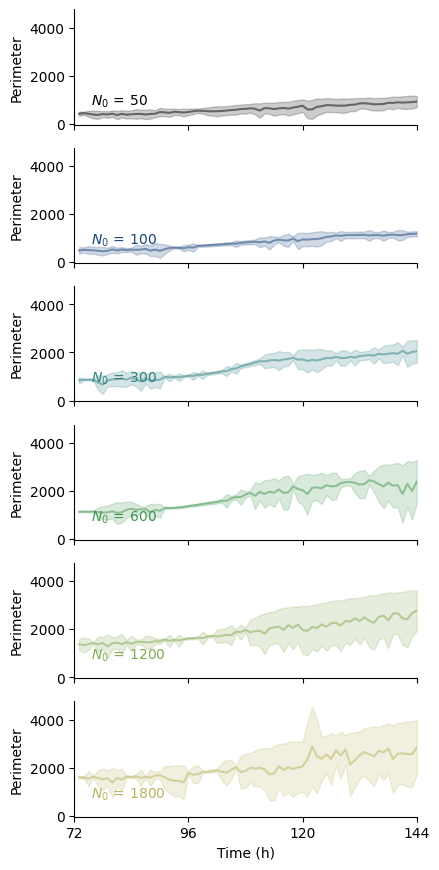

<Figure size 640x480 with 0 Axes>

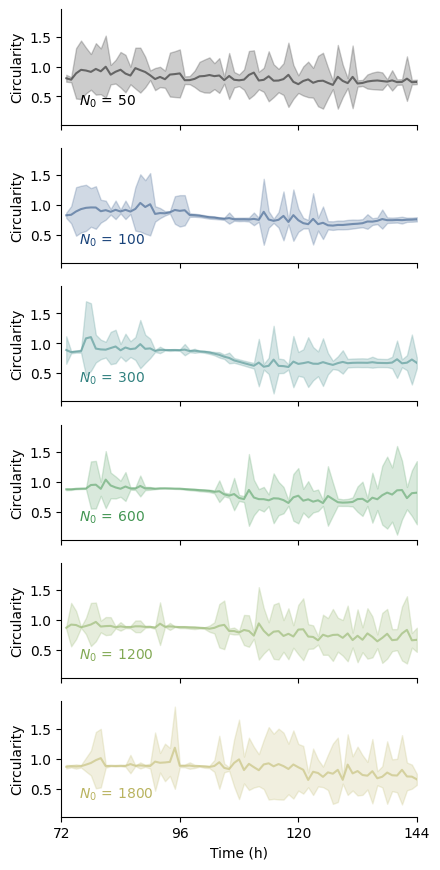

In [4]:
df_reshaped_long = pd.concat(df_reshaped_list, axis=1)
df_reshaped_long = df_reshaped_long.loc[:, ~df_reshaped_long.columns.duplicated()]

# Dictionnaire de couleurs
color_dict = {
    50: '#000000',
    100: '#184279',
    300: '#30807f',
    600: '#429552',
    1200: '#82a954',
    1800: '#b9b35f'
}

# Générer la palette de couleurs
colors = [color_dict.get(n, '#000000') for n in df_reshaped_long.Condition_int.unique()]

for df_plot, Colname in zip(df_reshaped_long, metrics):
    plt.figure()
    g = sns.FacetGrid(df_reshaped_long, row="Condition_int", hue="Condition_int", aspect=3, height=1.5)
    g.map(sns.lineplot, "Time (h)", Colname, errorbar='sd', alpha=0.5, hue_norm=(50, 4000))
    g.set(xlim=(72, 144), xticks=[72, 96, 120, 144])

    # Appliquer la palette de couleurs personnalisée
    sns.set_palette(sns.color_palette(colors))

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0.05, .2, '$N_0\,=\,$' + label, fontweight="normal", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "Time (h)")
    g.figure.subplots_adjust(hspace=+.2)
    g.set_titles("")



### Filtering: remove peaks and outliers

In [5]:
# List of conditions
metrics = ['AR', 'Area', 'Perimeter', 'Circularity']
conditions = df_reshaped_long['Condition_int'].unique()

# Normalize the data
df_normalized, normalization_params = pda.min_max_normalize(df_reshaped_long, metrics)

# Filter peaks and troughs
df_peaks_troughs = pda.filter_peaks_troughs(df_normalized, metrics)

# Replace negative values with NaNs
df_negative_filtered = pda.replace_negative_with_nan(df_peaks_troughs, metrics)

# Filter outliers using the 3-sigma rule with a rolling window
df_filtered_normalized = pda.filter_outliers(df_negative_filtered, metrics)

# Restore original data after filtering
df_filtered_original = pda.restore_original_data(df_reshaped_long, df_filtered_normalized, normalization_params, metrics)


metrics = ['AR', 'Area', 'Perimeter', 'Circularity']
conditions = df_normalized['Condition_int'].unique()
conditions = df_peaks_troughs['Condition_int'].unique()
conditions = df_negative_filtered['Condition_int'].unique()
conditions = df_filtered_normalized['Condition_int'].unique()
conditions = df_filtered_original['Condition_int'].unique()

### Figure S1D

Plot data after filtering. 

<Figure size 640x480 with 0 Axes>

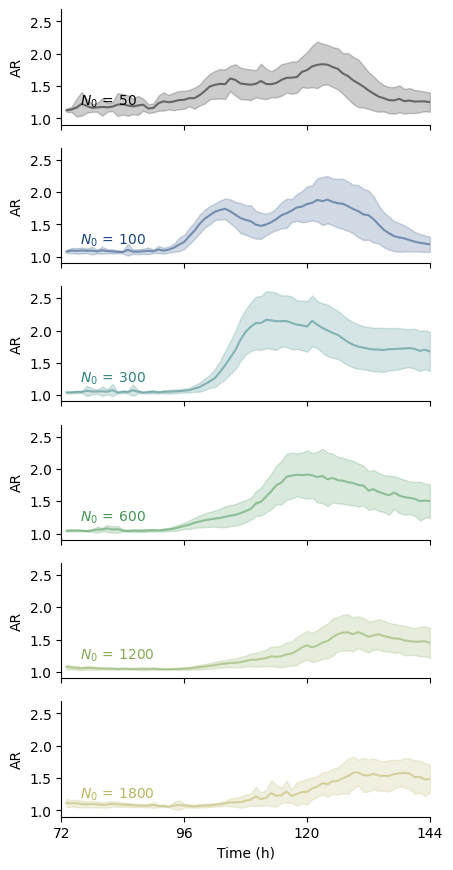

<Figure size 640x480 with 0 Axes>

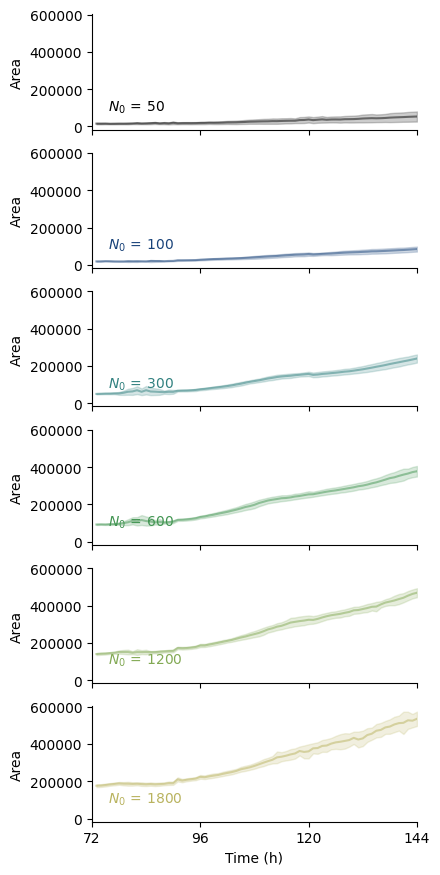

<Figure size 640x480 with 0 Axes>

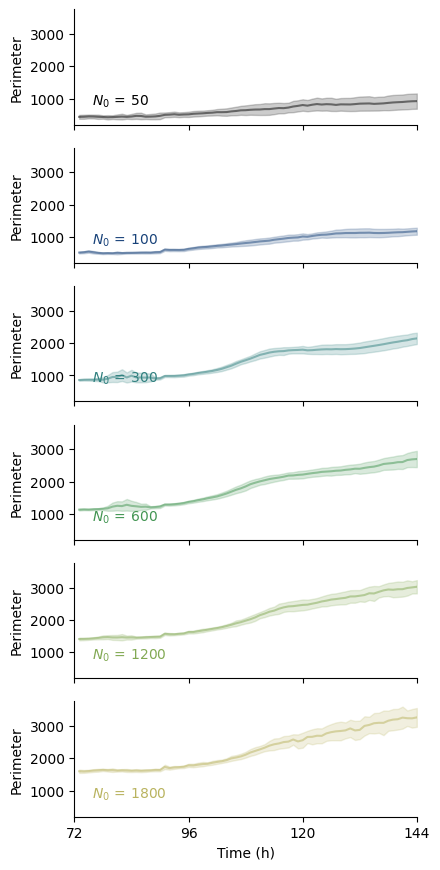

<Figure size 640x480 with 0 Axes>

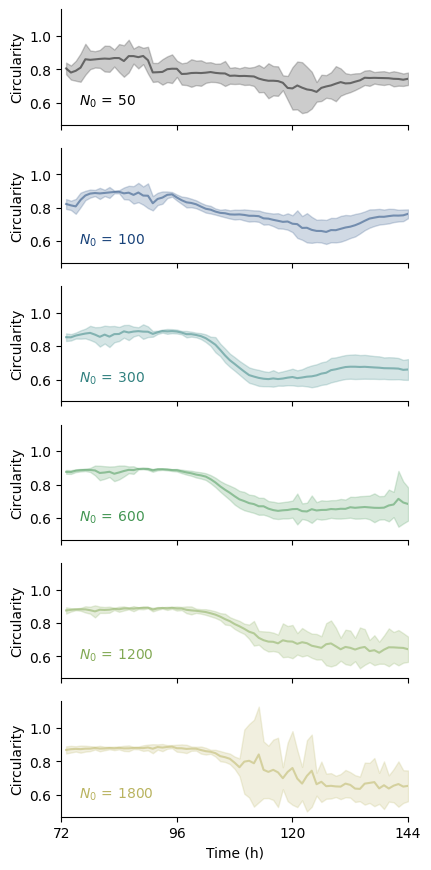

In [6]:
metrics = ['AR', 'Area', 'Perimeter', 'Circularity']

# Dictionnaire de couleurs
color_dict = {
    50: '#000000',
    100: '#184279',
    300: '#30807f',
    600: '#429552',
    1200: '#82a954',
    1800: '#b9b35f'
}

# Générer la palette de couleurs
colors = [color_dict.get(n, '#000000') for n in df_filtered_original.Condition_int.unique()]

for df_plot, Colname in zip(df_filtered_original, metrics):
    plt.figure()
    g = sns.FacetGrid(df_filtered_original, row="Condition_int", hue="Condition_int", aspect=3, height=1.5)
    g.map(sns.lineplot, "Time (h)", Colname, errorbar='sd', alpha=0.5, hue_norm=(50, 4000))
    g.set(xlim=(72, 144), xticks=[72, 96, 120, 144])

    # Appliquer la palette de couleurs personnalisée
    sns.set_palette(sns.color_palette(colors))

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0.05, .2, '$N_0\,=\,$' + label, fontweight="normal", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "Time (h)")
    g.figure.subplots_adjust(hspace=+.2)
    g.set_titles("")
  

### Figure 1D

Plot circularity vs aspect ratio. 

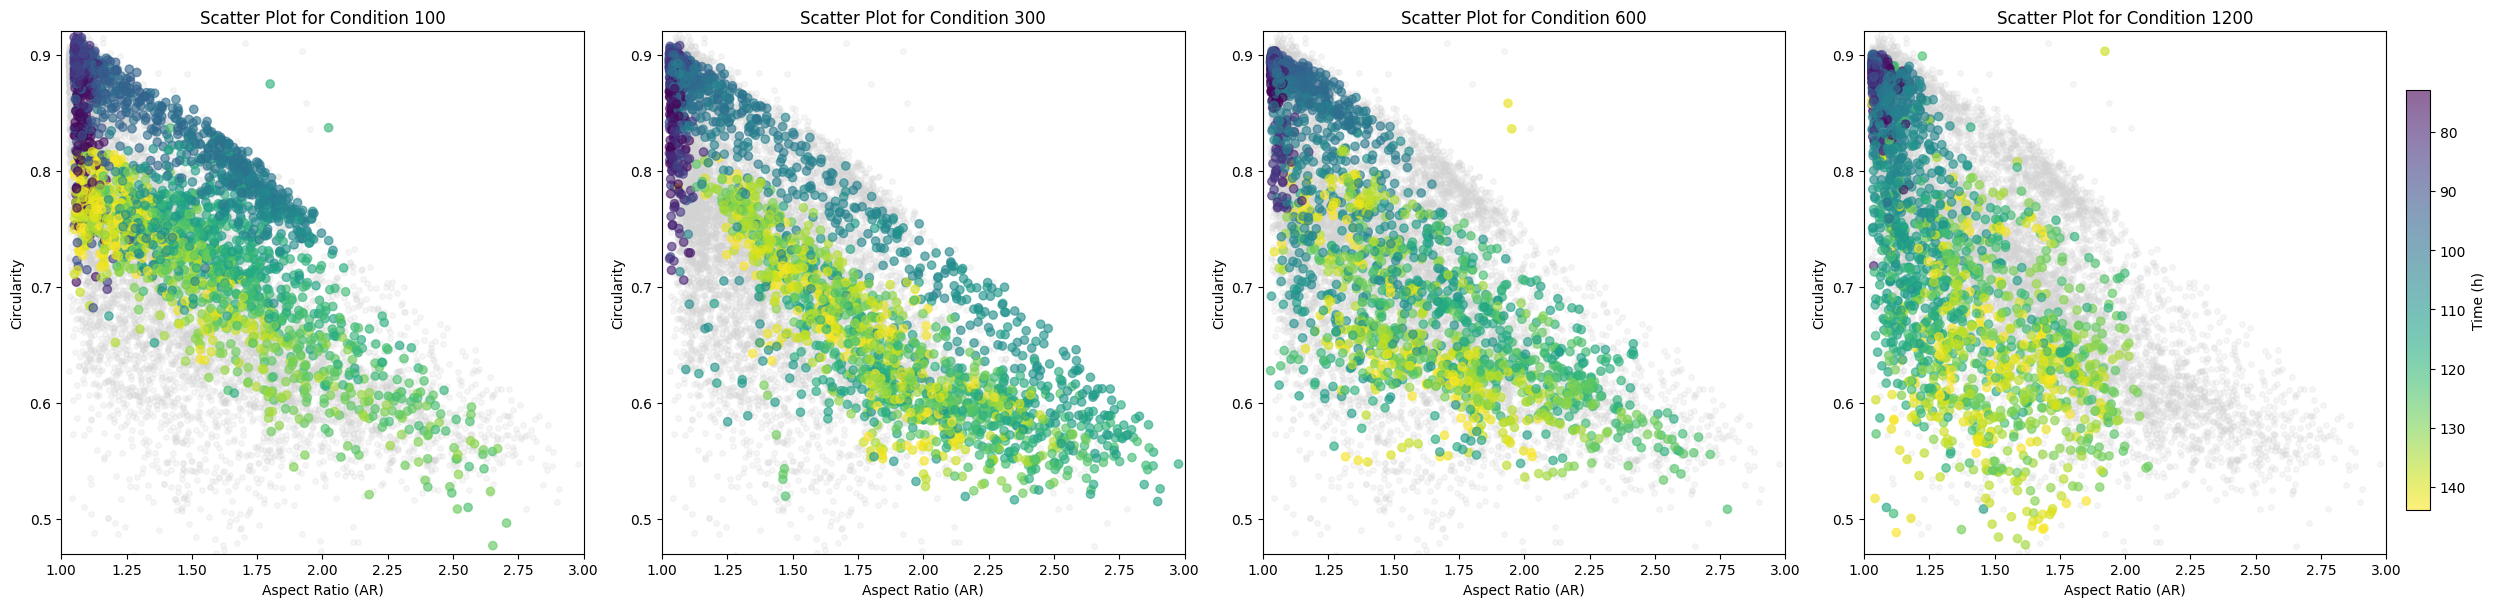

In [7]:
# Define the specific conditions to include
conditions_to_plot = [100, 300, 600, 1200]

# Create a figure with 1 row and 4 columns (4 subplots in a row)
fig, axs = plt.subplots(1, 4, figsize=(24, 6), constrained_layout=True)  # Adjusted figure size for better readability

# Flatten the axes array for easier indexing
axs = axs.ravel()

for idx, condition in enumerate(conditions_to_plot):  # Iterate over the specific conditions
    ax = axs[idx]

    # Plot all points in light gray in the background
    ax.scatter(
        x=df_filtered_original['AR'],
        y=df_filtered_original['Circularity'],
        color='lightgray',
        alpha=0.2,
        edgecolors=None,
        s=15  # Adjust this value to change the point size
    )

    # Filter data for the specific condition
    df_condition = df_filtered_original[df_filtered_original['Condition_int'] == condition]

    # Create the scatter plot for the specific condition
    scatter = ax.scatter(
        x=df_condition['AR'],  # Pass x values directly
        y=df_condition['Circularity'],  # Pass y values directly
        c=df_condition['Time (h)'],  # Color mapped to time
        cmap='viridis',  # Use the viridis colormap
        alpha=0.6,
        edgecolors=None
    )

    ax.set_xlabel('Aspect Ratio (AR)')
    ax.set_ylabel('Circularity')
    ax.set_title(f'Scatter Plot for Condition {condition}')
    ax.set_xlim(1, 3)
    ax.set_ylim(0.47, 0.92)

# Adjust aspect ratio for all subplots (equal aspect ratio)
for ax in axs:
    ax.set_box_aspect(1)  # Makes sure the box is square (1:1 aspect ratio)

# Create a colorbar for the whole figure
cbar_ax = fig.add_axes([1, 0.15, 0.01, 0.7])  # Position the colorbar further right
cbar = fig.colorbar(scatter, cax=cbar_ax)  # Create a single colorbar based on the last scatter plot
cbar.ax.invert_yaxis()  # Invert colorbar so higher values are on top
cbar.set_label('Time (h)')
cbar.ax.tick_params(labelsize=10)


# Show the plots
plt.show()


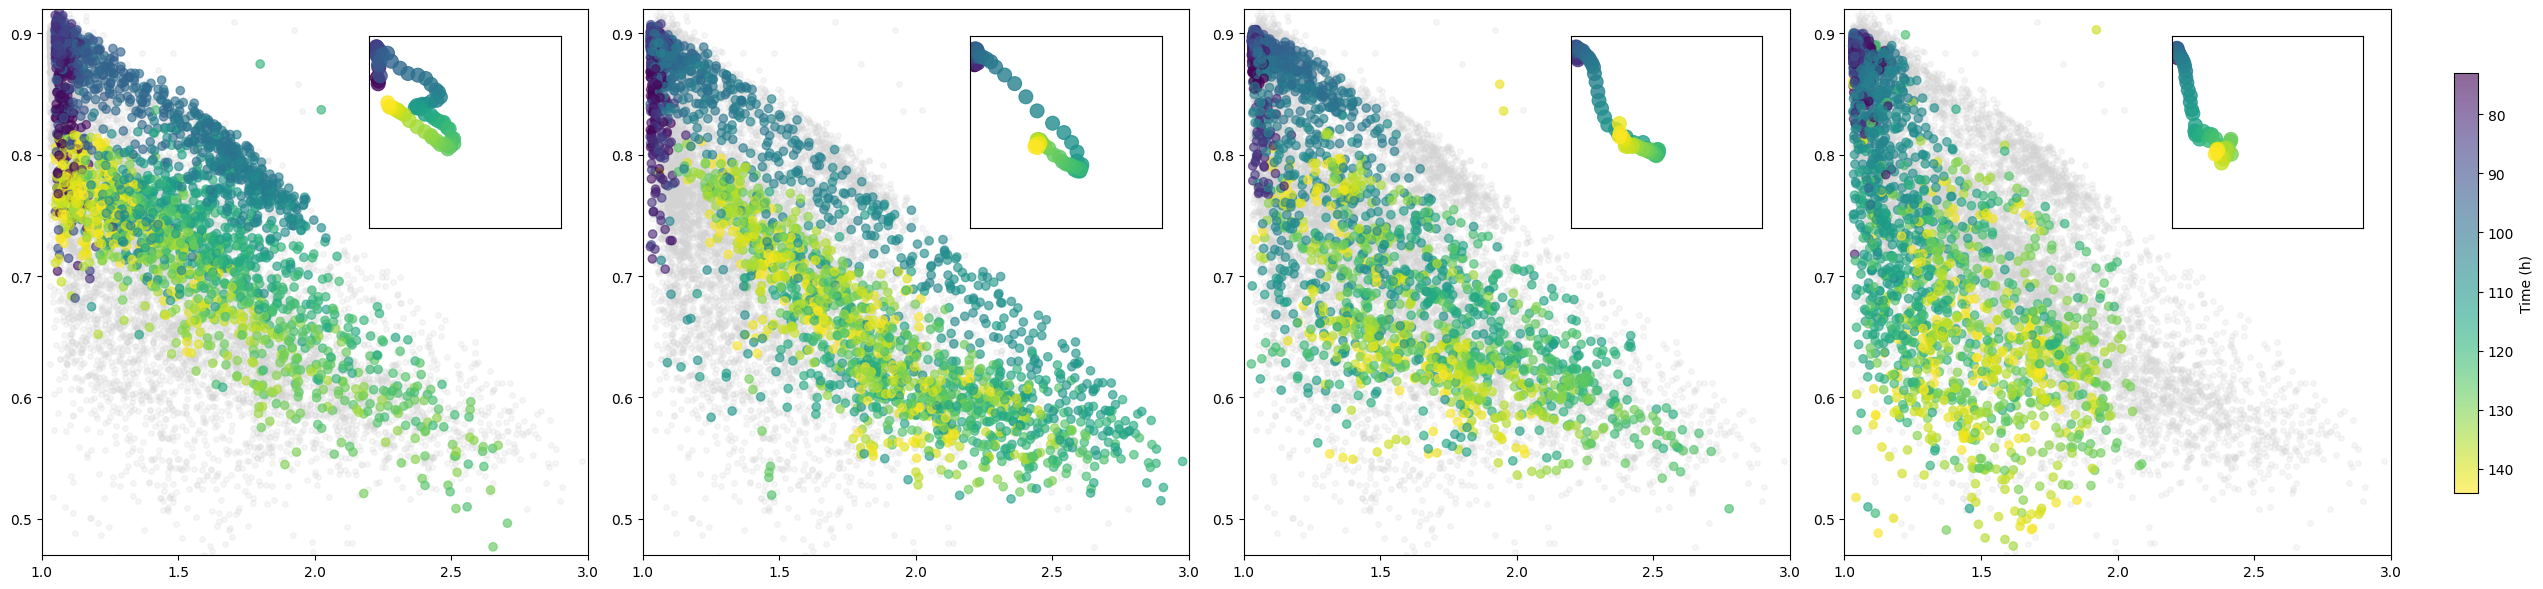

In [8]:
# Define the specific conditions to include
conditions_to_plot = [100, 300, 600, 1200]

# Create a figure with 1 row and 4 columns (4 subplots in a row)
fig, axs = plt.subplots(1, 4, figsize=(24, 6), constrained_layout=True)  # Adjusted figure size for better readability

# Flatten the axes array for easier indexing
axs = axs.ravel()

for idx, condition in enumerate(conditions_to_plot):  # Ensure only the specified conditions are plotted
    ax = axs[idx]

    # Plot all points in light gray in the background
    ax.scatter(
        x=df_filtered_original['AR'],
        y=df_filtered_original['Circularity'],
        color='lightgray',
        alpha=0.2,
        edgecolors=None,
        s=15  # Adjust this value to change the point size
    )

    # Filter data for the specific condition
    df_condition = df_filtered_original[df_filtered_original['Condition_int'] == condition]

    # Create the scatter plot for the specific condition
    scatter = ax.scatter(
        x=df_condition['AR'],  # Pass x values directly
        y=df_condition['Circularity'],  # Pass y values directly
        c=df_condition['Time (h)'],  # Color mapped to time
        cmap='viridis',  # Use the viridis colormap
        alpha=0.6,
        edgecolors=None
    )

    # Set the limits for axes
    ax.set_xlim(1, 3)
    ax.set_ylim(0.47, 0.92)

    # Add ticks manually (you can specify positions if needed)
    ax.xaxis.set_ticks([1, 1.5, 2, 2.5, 3])
    ax.yaxis.set_ticks(np.arange(0.50, 0.93, 0.1))  # Example ticks for y-axis

    # Create inset axes for the mean scatter plot
    inset_ax = ax.inset_axes([0.6, 0.6, 0.35, 0.35])  # [left, bottom, width, height]

    # Ensure only numeric columns are used for mean calculation
    numeric_cols = ['AR', 'Circularity']
    df_means = df_condition.groupby('Time (h)')[numeric_cols].mean().reset_index()

    # Scatter plot of means for the specific condition
    sns.scatterplot(
        data=df_means,
        x='AR',
        y='Circularity',
        hue='Time (h)',
        palette='viridis',
        s=100,  # Marker size
        alpha=0.8,
        edgecolor=None,
        ax=inset_ax  # Use the inset axes
    )

    # Remove axis labels, titles, and legends in inset
    inset_ax.set_xlabel('')
    inset_ax.set_ylabel('')
    inset_ax.set_title('')
    inset_ax.set_xticks([])  # Hide x-axis ticks
    inset_ax.set_yticks([])  # Hide y-axis ticks
    inset_ax.set_xlim(1, 3)
    inset_ax.set_ylim(0.47, 0.92)
    inset_ax.legend([], [], frameon=False)  # Suppress the default legend

# Adjust aspect ratio for all subplots (equal aspect ratio)
for ax in axs:
    ax.set_box_aspect(1)  # Makes sure the box is square (1:1 aspect ratio)

# Create a colorbar for the whole figure
cbar_ax = fig.add_axes([1.02, 0.15, 0.01, 0.7])  # Position the colorbar further right
cbar = fig.colorbar(scatter, cax=cbar_ax)  # Create a single colorbar based on the last scatter plot
cbar.ax.invert_yaxis()  # Invert colorbar so higher values are on top
cbar.set_label('Time (h)')  # Keep the label for the colorbar
cbar.ax.tick_params(labelsize=10)



# Show the plots
plt.show()


### Figure S1H

Aspect ratio spline fitting to identify transition times. 

Onset times for AR:
  Condition 100: 99 hours
  Condition 300: 106 hours
  Condition 600: 111 hours
  Condition 1200: 118 hours


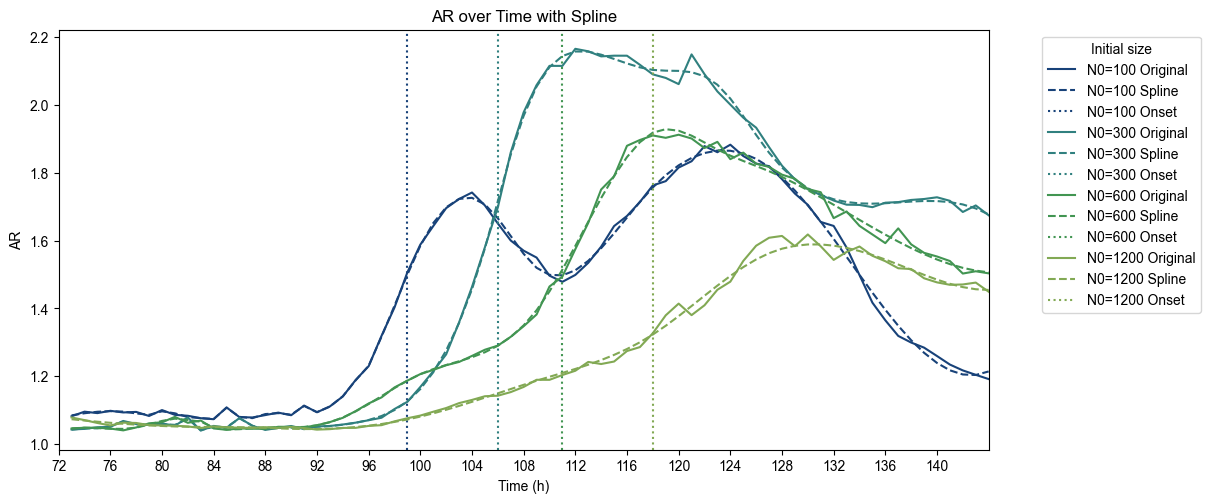

In [9]:


# Initialize dictionary to store onset times for each metric
metrics = ['AR']  # Add other metrics if needed
onset_times_dict_midpoint = {metric: {} for metric in metrics}

# Filter out conditions 50 and 1800
conditions = df_filtered_original['Condition_int'].unique()
conditions = [c for c in conditions if c not in [50, 1800]]  # Exclude 50 and 1800

# Color dictionary
color_dict = {
    100: '#184279',
    300: '#30807f',
    600: '#429552',
    1200: '#82a954'
}

# Generate the color palette
colors = [color_dict.get(n, '#000000') for n in conditions]

# Set the font to Arial
plt.rcParams['font.family'] = 'Arial'

# Iterate over each metric
for Colname in metrics:
    plt.figure(figsize=(12, 12))

    # Dataframe to store averaged values
    avg_df = pd.DataFrame()

    # Calculate mean values for each condition over time
    for condition in conditions:
        df_condition = df_filtered_original[df_filtered_original['Condition_int'] == condition]
        mean_values = df_condition.groupby('Time (h)')[Colname].mean().reset_index()
        std_values = df_condition.groupby('Time (h)')[Colname].std().reset_index()
        avg_df[f'{Colname}_N0={condition}'] = mean_values[Colname]
        if 'Time (h)' not in avg_df:
            avg_df['Time (h)'] = mean_values['Time (h)']

    time_values = avg_df['Time (h)'].values

    # Plot original data with means for each condition
    plt.subplot(2, 1, 1)
    for color_idx, condition in enumerate(conditions):
        original_values = avg_df[f'{Colname}_N0={condition}'].values
        std_values = df_condition.groupby('Time (h)')[Colname].std().values

        # Determine weights (inverse of standard deviation)
        weights = 1 / std_values

        # Find onset time using the midpoint method
        onset_time_midpoint, spline, spline_values, midpoint_value = pda.find_onset_time_midpoint(
            time_values, original_values, weights
        )

        # Store onset time
        onset_times_dict_midpoint[Colname][condition] = onset_time_midpoint

        # Plot original data
        plt.plot(time_values, original_values, label=f'N0={condition} Original', color=colors[color_idx])
        
        # Plot spline
        plt.plot(time_values, spline_values, label=f'N0={condition} Spline', color=colors[color_idx], linestyle='--')

        # Plot vertical line for onset time in the original data plot
        plt.axvline(x=onset_time_midpoint, color=colors[color_idx], linestyle=':', label=f'N0={condition} Onset')

    # Set ticks every 4 hours from 72 to 144 hours
    plt.xlim(72,144)
    plt.xticks(np.arange(72, 144, 4))

    plt.xlabel("Time (h)")
    plt.ylabel(Colname)
    plt.title(f'{Colname} over Time with Spline')
    plt.legend(title='Initial size', bbox_to_anchor=(1.05, 1), loc='upper left')

# Print onset times
for metric, times in onset_times_dict_midpoint.items():
    print(f"Onset times for {metric}:")
    for condition, onset_time in times.items():
        print(f"  Condition {condition}: {onset_time} hours")


### Figure 1E, 1F and S1G. 

Mean shape descriptors across time and cost function marking transition times

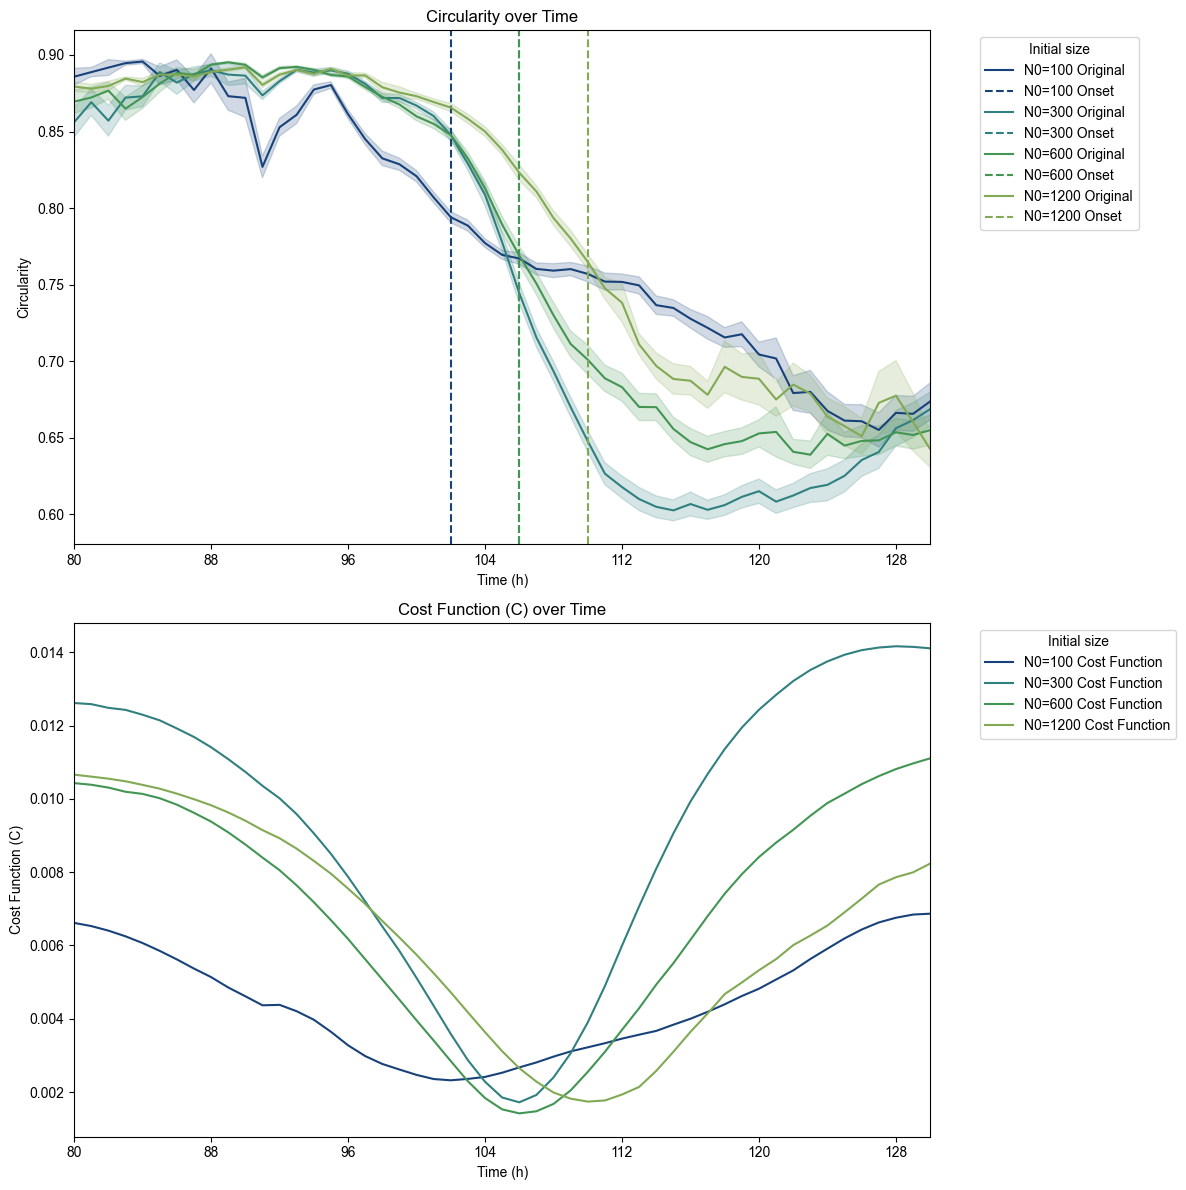

Onset times for Circularity using Cost Function:
  Condition 100: 102 hours
  Condition 300: 106 hours
  Condition 600: 106 hours
  Condition 1200: 110 hours


In [10]:


# Conditions and metrics
metrics = ['Circularity']
color_dict = {
    100: '#184279',
    300: '#30807f',
    600: '#429552',
    1200: '#82a954',
}

# Dictionary to store onset times
onset_times_dict_cost_function = {metric: {} for metric in metrics}


# Iterate over each metric
for Colname in metrics:
    plt.figure(figsize=(12, 12))
    
    # Dataframe to store averaged values and SEM
    avg_df = pd.DataFrame()
    sem_df = pd.DataFrame()  # To store SEM values

    # Calculate mean and SEM for each condition over time
    for condition in color_dict.keys():
        df_condition = df_filtered_original[df_filtered_original['Condition_int'] == condition]
        
        # Calculate mean and SEM grouped by time
        mean_values = df_condition.groupby('Time (h)')[Colname].mean().reset_index()
        sem_values = df_condition.groupby('Time (h)')[Colname].sem().reset_index()
        
        # Store the mean and SEM values
        avg_df[f'{Colname}_N0={condition}'] = mean_values[Colname]
        sem_df[f'{Colname}_N0={condition}'] = sem_values[Colname]
        
        if 'Time (h)' not in avg_df:
            avg_df['Time (h)'] = mean_values['Time (h)']
    
    time_values = avg_df['Time (h)']

    # Plot original data with means and SEM shaded area for each condition
    plt.subplot(2, 1, 1)
    for condition in color_dict.keys():
        original_values = avg_df[f'{Colname}_N0={condition}'].values
        sem_values = sem_df[f'{Colname}_N0={condition}'].values
        
        # Plot the mean values
        plt.plot(time_values, original_values, label=f'N0={condition} Original', color=color_dict[condition])
        
        # Add shaded region for SEM
        plt.fill_between(time_values, original_values - sem_values, original_values + sem_values,
                         color=color_dict[condition], alpha=0.2)
        
        # Find onset time using cost function method
        onset_time_cost_function, cost_values = pda.find_onset_time_cost_function(time_values.values, original_values)
        
        # Store onset time
        onset_times_dict_cost_function[Colname][condition] = onset_time_cost_function
        
        # Plot vertical line for onset time in the original data plot
        plt.axvline(x=onset_time_cost_function, color=color_dict[condition], linestyle='--', label=f'N0={condition} Onset')
    
    plt.xlabel("Time (h)")
    plt.ylabel(Colname)
    plt.title(f'{Colname} over Time')
    plt.xlim(80, 130)  # Set x-axis limits from 80 to 130 hours
    
    # Set x-axis ticks every 4 hours
    plt.xticks(np.arange(80, 130, 8))
    plt.legend(title='Initial size',bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot cost function values
    plt.subplot(2, 1, 2)
    for condition in color_dict.keys():
        # Compute cost function for each condition
        original_values = avg_df[f'{Colname}_N0={condition}'].values
        _, cost_values = pda.find_onset_time_cost_function(time_values.values, original_values)
        
        # Plot cost function
        plt.plot(time_values[2:-2], cost_values, label=f'N0={condition} Cost Function', color=color_dict[condition])
    
    plt.xlabel("Time (h)")
    plt.ylabel('Cost Function (C)')
    plt.title('Cost Function (C) over Time')
    plt.xlim(80, 130)  # Set x-axis limits from 80 to 130 hours
    plt.xticks(np.arange(80, 130, 8))
    plt.legend(title='Initial size',bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Print onset times
for metric, times in onset_times_dict_cost_function.items():
    print(f"Onset times for {metric} using Cost Function:")
    for condition, onset_time in times.items():
        print(f"  Condition {condition}: {onset_time} hours")


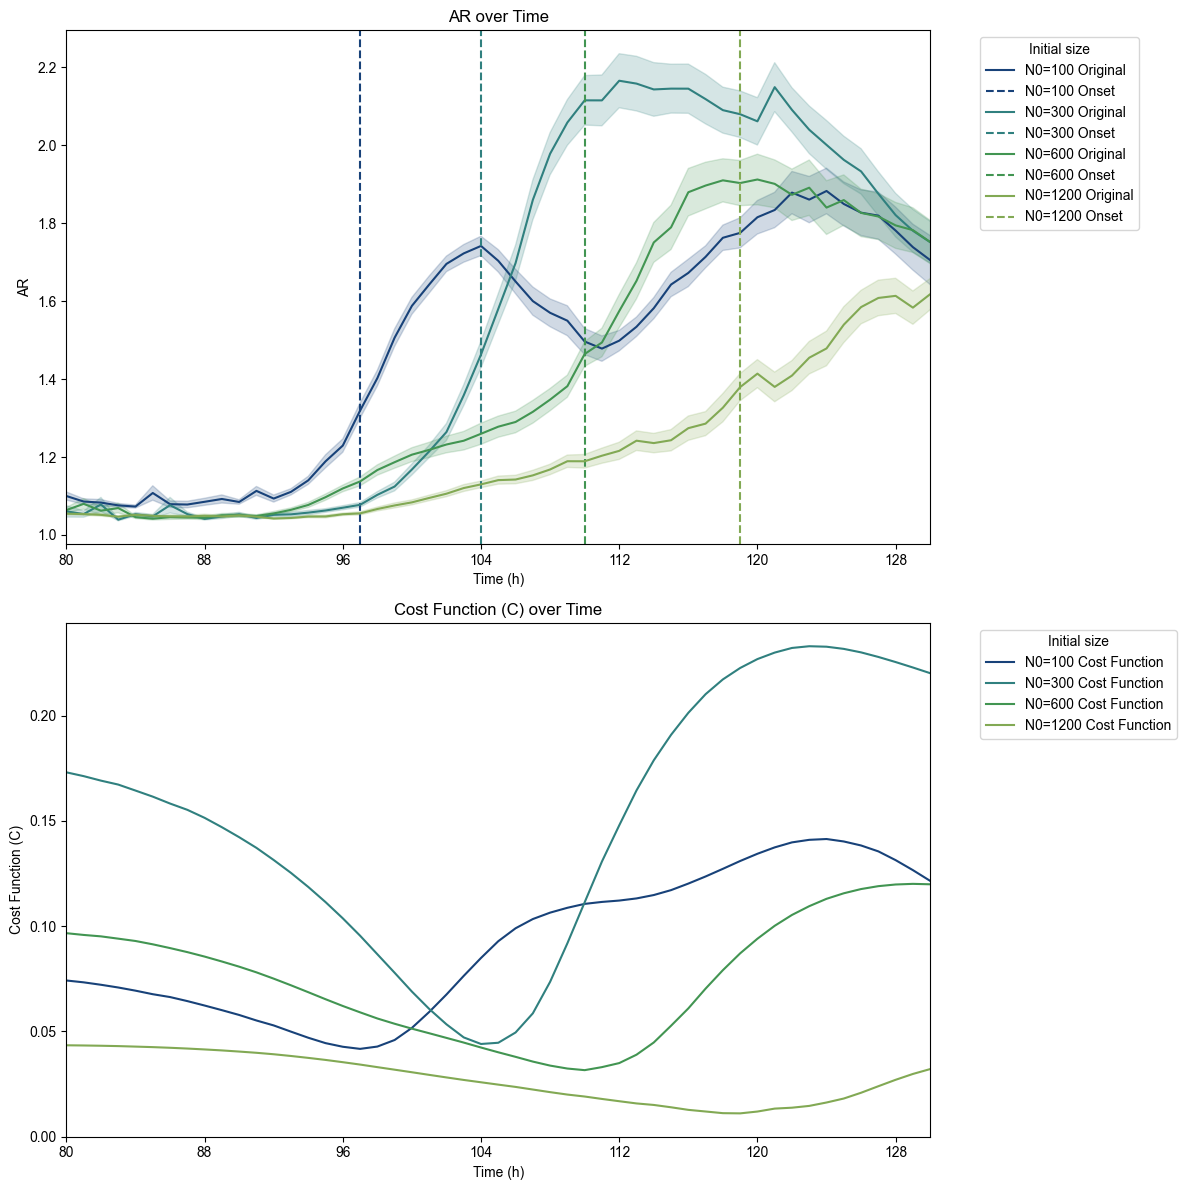

Onset times for AR using Cost Function:
  Condition 100: 97 hours
  Condition 300: 104 hours
  Condition 600: 110 hours
  Condition 1200: 119 hours


In [11]:
# Conditions and metrics
metrics = ['AR']
color_dict = {
    100: '#184279',
    300: '#30807f',
    600: '#429552',
    1200: '#82a954',
}

# Dictionary to store onset times
onset_times_dict_cost_function = {metric: {} for metric in metrics}


# Iterate over each metric
for Colname in metrics:
    plt.figure(figsize=(12, 12))
    
    # Dataframe to store averaged values and SEM
    avg_df = pd.DataFrame()
    sem_df = pd.DataFrame()  # To store SEM values

    # Calculate mean and SEM for each condition over time
    for condition in color_dict.keys():
        df_condition = df_filtered_original[df_filtered_original['Condition_int'] == condition]
        
        # Calculate mean and SEM grouped by time
        mean_values = df_condition.groupby('Time (h)')[Colname].mean().reset_index()
        sem_values = df_condition.groupby('Time (h)')[Colname].sem().reset_index()
        
        # Store the mean and SEM values
        avg_df[f'{Colname}_N0={condition}'] = mean_values[Colname]
        sem_df[f'{Colname}_N0={condition}'] = sem_values[Colname]
        
        if 'Time (h)' not in avg_df:
            avg_df['Time (h)'] = mean_values['Time (h)']
    
    time_values = avg_df['Time (h)']

    # Plot original data with means and SEM shaded area for each condition
    plt.subplot(2, 1, 1)
    for condition in color_dict.keys():
        original_values = avg_df[f'{Colname}_N0={condition}'].values
        sem_values = sem_df[f'{Colname}_N0={condition}'].values
        
        # Plot the mean values
        plt.plot(time_values, original_values, label=f'N0={condition} Original', color=color_dict[condition])
        
        # Add shaded region for SEM
        plt.fill_between(time_values, original_values - sem_values, original_values + sem_values,
                         color=color_dict[condition], alpha=0.2)
        
        # Find onset time using cost function method
        onset_time_cost_function, cost_values = pda.find_onset_time_cost_function(time_values.values, original_values)
        
        # Store onset time
        onset_times_dict_cost_function[Colname][condition] = onset_time_cost_function
        
        # Plot vertical line for onset time in the original data plot
        plt.axvline(x=onset_time_cost_function, color=color_dict[condition], linestyle='--', label=f'N0={condition} Onset')
    
    plt.xlabel("Time (h)")
    plt.ylabel(Colname)
    plt.title(f'{Colname} over Time')
    plt.xlim(80, 130)  # Set x-axis limits from 80 to 130 hours
    
    # Set x-axis ticks every 4 hours
    plt.xticks(np.arange(80, 130, 8))
    
    plt.legend(title='Initial size',bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot cost function values
    plt.subplot(2, 1, 2)
    for condition in color_dict.keys():
        # Compute cost function for each condition
        original_values = avg_df[f'{Colname}_N0={condition}'].values
        _, cost_values = pda.find_onset_time_cost_function(time_values.values, original_values)
        
        # Plot cost function
        plt.plot(time_values[2:-2], cost_values, label=f'N0={condition} Cost Function', color=color_dict[condition])
    
    plt.xlabel("Time (h)")
    plt.ylabel('Cost Function (C)')
    plt.title('Cost Function (C) over Time')
    plt.xlim(80, 130)  # Set x-axis limits from 80 to 130 hours
    plt.xticks(np.arange(80, 130, 8))
    
    plt.legend(title='Initial size',bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Print onset times
for metric, times in onset_times_dict_cost_function.items():
    print(f"Onset times for {metric} using Cost Function:")
    for condition, onset_time in times.items():
        print(f"  Condition {condition}: {onset_time} hours")


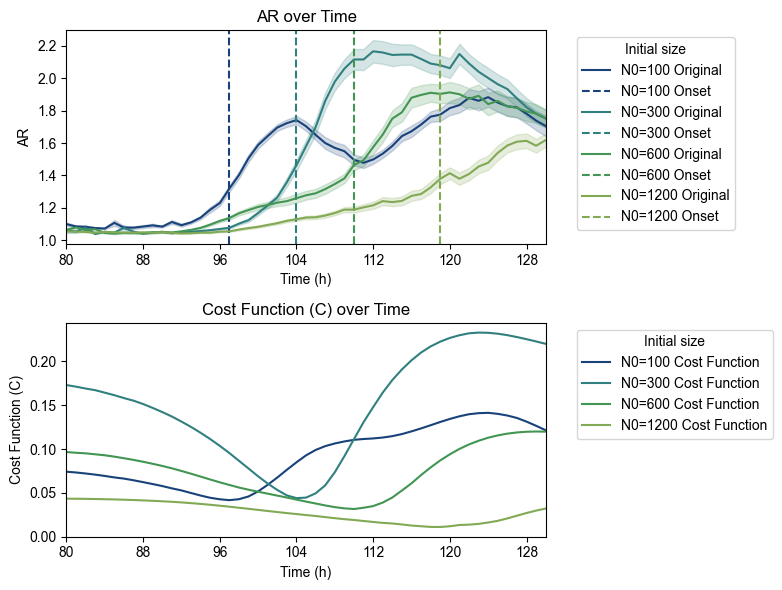

Onset times for AR using Cost Function:
  Condition 100: 97 hours
  Condition 300: 104 hours
  Condition 600: 110 hours
  Condition 1200: 119 hours


In [12]:
# Conditions and metrics
metrics = ['AR']
color_dict = {
    100: '#184279',
    300: '#30807f',
    600: '#429552',
    1200: '#82a954',
}

# Dictionary to store onset times
onset_times_dict_cost_function = {metric: {} for metric in metrics}


# Iterate over each metric
for Colname in metrics:
    plt.figure(figsize=(8, 6))
    
    # Dataframe to store averaged values and SEM
    avg_df = pd.DataFrame()
    sem_df = pd.DataFrame()  # To store SEM values

    # Calculate mean and SEM for each condition over time
    for condition in color_dict.keys():
        df_condition = df_filtered_original[df_filtered_original['Condition_int'] == condition]
        
        # Calculate mean and SEM grouped by time
        mean_values = df_condition.groupby('Time (h)')[Colname].mean().reset_index()
        sem_values = df_condition.groupby('Time (h)')[Colname].sem().reset_index()
        
        # Store the mean and SEM values
        avg_df[f'{Colname}_N0={condition}'] = mean_values[Colname]
        sem_df[f'{Colname}_N0={condition}'] = sem_values[Colname]
        
        if 'Time (h)' not in avg_df:
            avg_df['Time (h)'] = mean_values['Time (h)']
    
    time_values = avg_df['Time (h)']

    # Plot original data with means and SEM shaded area for each condition
    plt.subplot(2, 1, 1)
    for condition in color_dict.keys():
        original_values = avg_df[f'{Colname}_N0={condition}'].values
        sem_values = sem_df[f'{Colname}_N0={condition}'].values
        
        # Plot the mean values
        plt.plot(time_values, original_values, label=f'N0={condition} Original', color=color_dict[condition])
        
        # Add shaded region for SEM
        plt.fill_between(time_values, original_values - sem_values, original_values + sem_values,
                         color=color_dict[condition], alpha=0.2)
        
        # Find onset time using cost function method
        onset_time_cost_function, cost_values = pda.find_onset_time_cost_function(time_values.values, original_values)
        
        # Store onset time
        onset_times_dict_cost_function[Colname][condition] = onset_time_cost_function
        
        # Plot vertical line for onset time in the original data plot
        plt.axvline(x=onset_time_cost_function, color=color_dict[condition], linestyle='--', label=f'N0={condition} Onset')
    
    plt.xlabel("Time (h)")
    plt.ylabel(Colname)
    plt.title(f'{Colname} over Time')
    plt.xlim(80, 130)  # Set x-axis limits from 80 to 130 hours
    
    # Set x-axis ticks every 4 hours
    plt.xticks(np.arange(80, 130, 8))
    
    plt.legend(title='Initial size',bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot cost function values
    plt.subplot(2, 1, 2)
    for condition in color_dict.keys():
        # Compute cost function for each condition
        original_values = avg_df[f'{Colname}_N0={condition}'].values
        _, cost_values = pda.find_onset_time_cost_function(time_values.values, original_values)
        
        # Plot cost function
        plt.plot(time_values[2:-2], cost_values, label=f'N0={condition} Cost Function', color=color_dict[condition])
    
    plt.xlabel("Time (h)")
    plt.ylabel('Cost Function (C)')
    plt.title('Cost Function (C) over Time')
    plt.xlim(80, 130)  # Set x-axis limits from 80 to 130 hours
    plt.xticks(np.arange(80, 130, 8))
    
    plt.legend(title='Initial size',bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()    
    plt.show()

# Print onset times
for metric, times in onset_times_dict_cost_function.items():
    print(f"Onset times for {metric} using Cost Function:")
    for condition, onset_time in times.items():
        print(f"  Condition {condition}: {onset_time} hours")


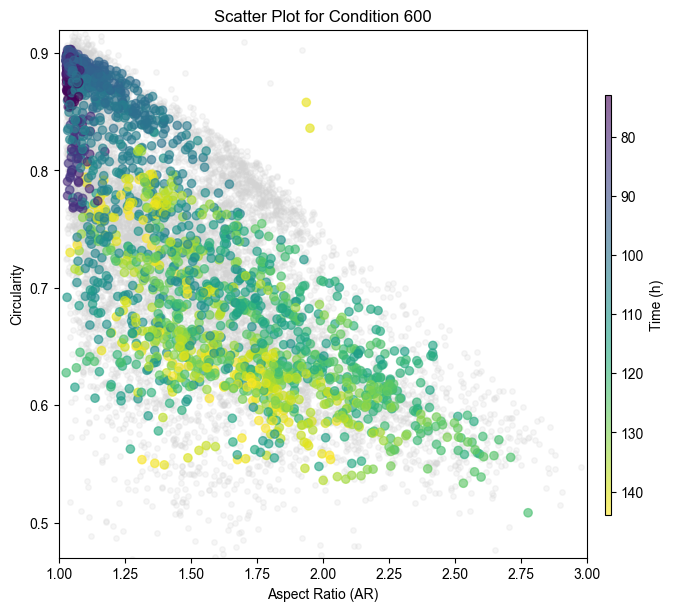

In [13]:
# Define the specific conditions to include
conditions_to_plot = [600]

# Create a figure with 1 row and 4 columns (4 subplots in a row)
fig, axs = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)  # Adjusted figure size for better readability


for idx, condition in enumerate(conditions_to_plot):  # Iterate over the specific conditions
    ax = axs

    # Plot all points in light gray in the background
    ax.scatter(
        x=df_filtered_original['AR'],
        y=df_filtered_original['Circularity'],
        color='lightgray',
        alpha=0.2,
        edgecolors=None,
        s=15  # Adjust this value to change the point size
    )

    # Filter data for the specific condition
    df_condition = df_filtered_original[df_filtered_original['Condition_int'] == condition]

    # Create the scatter plot for the specific condition
    scatter = ax.scatter(
        x=df_condition['AR'],  # Pass x values directly
        y=df_condition['Circularity'],  # Pass y values directly
        c=df_condition['Time (h)'],  # Color mapped to time
        cmap='viridis',  # Use the viridis colormap
        alpha=0.6,
        edgecolors=None
    )

    ax.set_xlabel('Aspect Ratio (AR)')
    ax.set_ylabel('Circularity')
    ax.set_title(f'Scatter Plot for Condition {condition}')
    ax.set_xlim(1, 3)
    ax.set_ylim(0.47, 0.92)


ax.set_box_aspect(1)  # Makes sure the box is square (1:1 aspect ratio)

# Create a colorbar for the whole figure
cbar_ax = fig.add_axes([1, 0.15, 0.01, 0.7])  # Position the colorbar further right
cbar = fig.colorbar(scatter, cax=cbar_ax)  # Create a single colorbar based on the last scatter plot
cbar.ax.invert_yaxis()  # Invert colorbar so higher values are on top
cbar.set_label('Time (h)')
cbar.ax.tick_params(labelsize=10)


# Show the plots
plt.show()


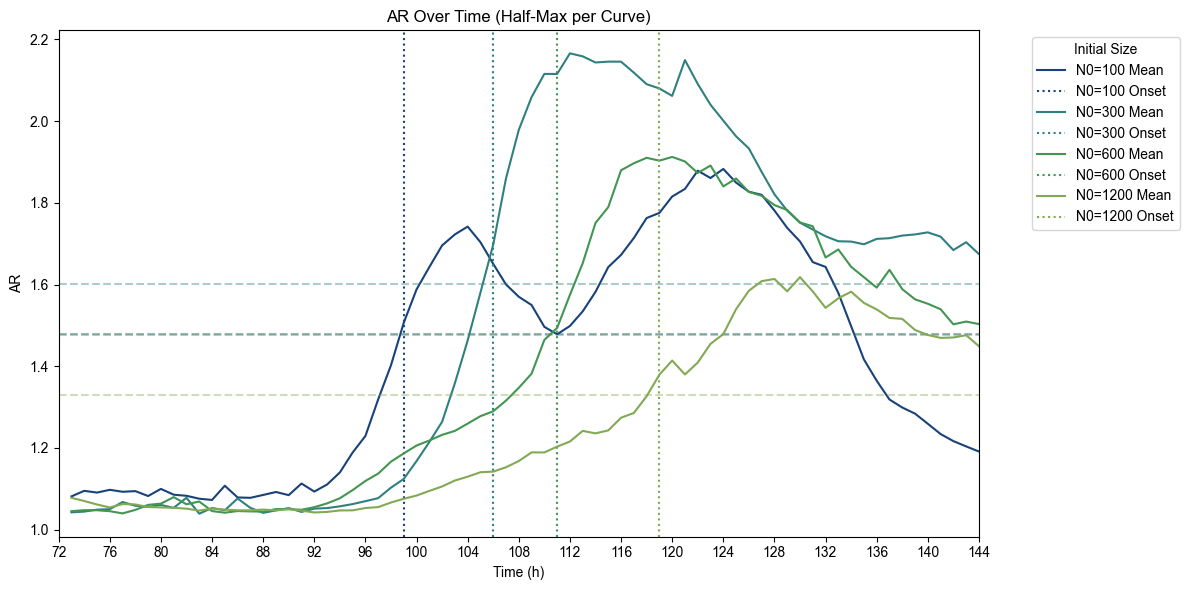

Onset times for AR (half-max per curve):
  Condition 100: 99 hours
  Condition 300: 106 hours
  Condition 600: 111 hours
  Condition 1200: 119 hours


In [14]:
#### Find AR transition times with half-max method
metrics = ['AR']
onset_times_dict_halfmax = {metric: {} for metric in metrics}

conditions = df_filtered_original['Condition_int'].unique()
conditions = [c for c in conditions if c not in [50, 1800]]

colors = [color_dict.get(n, '#000000') for n in conditions]
plt.rcParams['font.family'] = 'Arial'

for Colname in metrics:
    plt.figure(figsize=(12, 6))
    avg_df = pd.DataFrame()

    
    for condition in conditions:
        df_condition = df_filtered_original[df_filtered_original['Condition_int'] == condition]
        mean_values = df_condition.groupby('Time (h)')[Colname].mean().reset_index()
        avg_df[f'{Colname}_N0={condition}'] = mean_values[Colname]
        if 'Time (h)' not in avg_df:
            avg_df['Time (h)'] = mean_values['Time (h)']

    time_values = avg_df['Time (h)'].values

 
    for color_idx, condition in enumerate(conditions):
        curve = avg_df[f'{Colname}_N0={condition}'].values

        
        min_val = np.nanmin(curve)
        max_val = np.nanmax(curve)
        halfmax = (min_val + max_val) / 2

        # first time curve crosses half-max threshold
        try:
            onset_idx = np.where(curve >= halfmax)[0][0]
            onset_time = time_values[onset_idx]
        except IndexError:
            onset_time = np.nan  # never crosses

        onset_times_dict_halfmax[Colname][condition] = onset_time

    
        plt.plot(time_values, curve, label=f'N0={condition} Mean', color=colors[color_idx])
        plt.axhline(y=halfmax, color=colors[color_idx], linestyle='--', alpha=0.4)
        if not np.isnan(onset_time):
            plt.axvline(x=onset_time, color=colors[color_idx], linestyle=':', label=f'N0={condition} Onset')

    ####
    plt.xlim(72, 144)
    plt.xticks(np.arange(72, 145, 4))
    plt.xlabel("Time (h)")
    plt.ylabel(Colname)
    plt.title(f'{Colname} Over Time (Half-Max per Curve)')
    plt.legend(title='Initial Size', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    #plt.savefig(f'{Colname}_onset_times_halfmax_individual.svg', format='svg', bbox_inches='tight')
    plt.show()

#Print times
for metric, times in onset_times_dict_halfmax.items():
    print(f"Onset times for {metric} (half-max per curve):")
    for condition, onset_time in times.items():
        print(f"  Condition {condition}: {onset_time} hours")


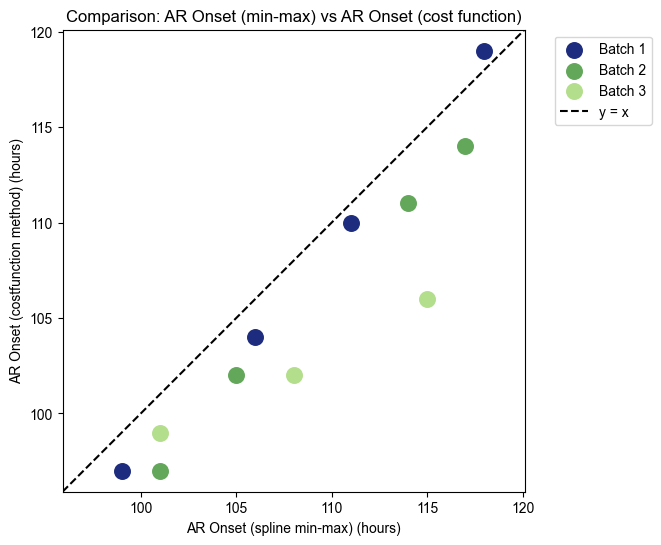

<Figure size 640x480 with 0 Axes>

In [15]:
#Scatter plots to compare two transition time methods

# Example data
batch_data = {
    1: {'Condition': [100, 300, 600, 1200],
        'AR_Onset': [97, 104, 110, 119],
        'ARminmax_Onset': [99, 106, 111, 118]
        
    },
    2: {'Condition': [100, 300, 600, 1200],
        'AR_Onset': [97, 102, 111, 114],
        'ARminmax_Onset': [101, 105, 114, 117]
        
    },
    3: {
        'Condition': [300, 600, 1200],
        'AR_Onset': [99, 102, 106],
        'ARminmax_Onset': [101, 108, 115]
    }
}

# Matplotlib 
plt.rcParams["font.family"] = "Arial"
plt.figure(figsize=(6, 6))

colors = {1: '#1D2C7F', 2: '#62A75A', 3: '#B3DE8C'}
marker = 'o'
marker_size = 125

all_arminmax_values = []
all_ar_values = []

for batch, data in batch_data.items():
    x_arminmax = data['ARminmax_Onset']
    y_ar = data['AR_Onset']
    
    plt.scatter(
        x_arminmax, y_ar,
        color=colors[batch],
        marker=marker,
        s=marker_size,
        label=f'Batch {batch}'
    )
    
    all_arminmax_values.extend(x_arminmax)
    all_ar_values.extend(y_ar)


combined_values = np.array(all_arminmax_values + all_ar_values)
min_val, max_val = np.min(combined_values), np.max(combined_values)
padding = (max_val - min_val) * 0.05  # 5% padding

plt.xlim(min_val - padding, max_val + padding)
plt.ylim(min_val - padding, max_val + padding)
plt.gca().set_aspect('equal', adjustable='box')


diagonal = np.linspace(min_val - padding, max_val + padding, 100)
plt.plot(diagonal, diagonal, color='black', linestyle='--', label='y = x')


plt.xlabel('AR Onset (spline min-max) (hours)')
plt.ylabel('AR Onset (costfunction method) (hours)')
plt.title('Comparison: AR Onset (min-max) vs AR Onset (cost function)')


handles, labels = plt.gca().get_legend_handles_labels()
unique_dict = dict(zip(labels, handles))
plt.legend(unique_dict.values(), unique_dict.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
transitioncompariaison = "transition_compariaison"

svg_filename = transitioncompariaison + ".svg"
pdf_filename = transitioncompariaison + ".pdf"

# Then save:
#plt.savefig(svg_filename)
#plt.savefig(pdf_filename)

plt.show()

plt.tight_layout()
plt.show()
